In [ ]:
# Associative Rule Mining to identify similar positions --> WQ
# all possibilites of agg, divisive clustering --> Nits
# Dbscan + Visualisation --> WQ
# CURE + Visualisation --> Nits

In [171]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../../datasets/soccer_player_embeddings_v1.csv')
df

,id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,player_fifa_api_id,player_api_id,overall_rating,potential,player_name,birthday,player_positions
0,97455,-0.020058,0.683692,-0.255270,-0.329416,-0.594869,0.124635,-0.209664,0.304167,-0.082228,...,0.047019,-0.091479,0.273118,119152,30831,78.0,78.0,Kolo Toure,1981-03-19 00:00:00,CB
1,42881,0.068503,0.188564,-0.228424,-0.542123,-0.304828,0.015172,0.001972,-0.151031,-0.113127,...,-0.188535,0.258280,-0.195703,199284,133126,63.0,63.0,Dennis Hediger,1986-09-22 00:00:00,"CDM, CM, CAM"
2,97483,2.236177,-0.317256,1.209209,0.559709,0.488686,0.023748,-0.034294,-0.239571,-0.111753,...,-0.245468,0.054037,0.010629,201169,206641,58.0,63.0,Konrad Forenc,1992-07-17 00:00:00,GK
3,97505,-0.553902,0.108279,-0.700631,1.268173,0.137731,-0.259513,0.327372,-0.145581,-0.180327,...,-0.004284,-0.028598,-0.068586,183559,11242,67.0,67.0,Konstantin Engel,1988-07-27 00:00:00,"RB, LB"
4,42402,0.235236,-0.260011,1.173912,-0.533751,0.475334,-0.042503,-0.011437,-0.537734,0.061248,...,0.065391,-0.188249,0.083385,225951,664962,64.0,75.0,Denis Bouanga,1994-11-11 00:00:00,"RW, ST"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,153509,-0.025461,-0.231916,-0.528128,-0.564062,1.004626,0.639091,0.287734,0.037770,-0.207479,...,-0.104830,0.296571,0.210710,172555,45400,68.0,70.0,Ronnie Schwartz,1989-08-29 00:00:00,ST
6354,95621,0.285636,-0.168007,-0.540073,-0.391587,0.996375,0.933036,-0.012724,-0.056702,-0.354121,...,-0.217510,0.164363,-0.001703,208127,307224,64.0,68.0,Kevin Koubemba,1993-03-23 00:00:00,ST
6355,19676,-0.298870,-0.260222,-0.520168,-0.737590,1.051284,0.613741,-0.062358,0.262144,-0.146928,...,-0.362669,-0.112991,-0.015201,166074,210065,72.0,75.0,Bebe,1990-07-12 00:00:00,"LM, RM, RW, ST"
6356,81812,0.105301,-0.597632,-0.138244,-0.930273,0.135653,-0.348811,0.387094,-0.476624,0.106154,...,0.143886,-0.055698,0.344106,228738,423024,67.0,79.0,Jhon Murillo,1995-11-21 00:00:00,"LW, RW"


In [5]:
X = df.iloc[:, 1:15]

In [6]:
y = df['player_positions']

In [7]:
labels = []
for l in y.values:
    if ',' in l:
        labels.extend(l.split(", "))
    else:
        labels.append(l)

labels, counts = np.unique(labels, return_counts=True)
for i, l in enumerate(labels):
    print("Position: {}, count {}".format(l, counts[i]))

Position: CAM, count 887
Position: CB, count 1326
Position: CDM, count 1098
Position: CF, count 229
Position: CM, count 1326
Position: GK, count 561
Position: LB, count 754
Position: LM, count 906
Position: LW, count 357
Position: LWB, count 44
Position: RB, count 779
Position: RM, count 918
Position: RW, count 390
Position: RWB, count 29
Position: ST, count 1157


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(5086, 14)
(1272, 14)


# Clustering Techniques

## KMeans

In [9]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=16, random_state=42).fit(X_train)

In [18]:
given_cluster = kmeans.labels_
given_cluster

array([ 6, 10,  0, ..., 10,  9,  3], dtype=int32)

## Agglomerative Clustering

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [143]:
def find_elbow(linkageArr, startSearch=1, title=None):
    last = linkageArr[-20:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    
    if title:
        plt.title("Elbow search for {}".format(title))
    else:
        plt.title("Elbow search")
    plt.plot(idxs, last_rev, label="Distances")
    plt.plot(idxs[:-2] + 1, acceleration_rev, label="2nd Derviv")
    plt.legend(loc="best")
    plt.show()

    k = acceleration_rev[startSearch:].argmax() + 2 + startSearch  # if idx 0 is the max of this we want 2 clusters
    max_dist = last_rev[k-2]
    print("clusters: {} at max_dist: {}".format(k, max_dist))
    
    return k, max_dist

In [105]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

def plot_dendogram(linkageArr, numClusters, maxDist=None, title=None):
    plt.figure(figsize=(15,7))
    if title:
        plt.title('Hierarchical Clustering Dendrogram (truncated) for {}'.format(title))
    else:
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
    fancy_dendrogram(
        linkageArr,
        truncate_mode='lastp',
        p=numClusters,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,
        max_d=maxDist,
    )
    plt.show()

In [120]:
def agg_with_kmeans(num_clusters, title=None):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X_train)
    given_cluster = kmeans.labels_
    
    y_train_vals = y_train.values
    classes_in_cluster = np.zeros(shape=(num_clusters, len(labels)), dtype=int)
    for i in range(num_clusters):
        dataInd = np.argwhere(given_cluster==i).flatten()
        for ind in dataInd:
            if ',' in y_train_vals[ind]:
                split = y_train_vals[ind].split(', ')
                for s in split:
                    j, = np.where(labels == s)
                    classes_in_cluster[i][j] += 1
            else:
                j, = np.where(labels == y_train_vals[ind])
                classes_in_cluster[i][j] += 1
    
    plt.figure(figsize=(15,5))
    if title:
        plt.title("Labels within clusters by {}".format(title))
    else:
        plt.title("Labels within clusters")
    sns.heatmap(classes_in_cluster, annot=True, cmap='Blues', fmt="d")
    plt.xticks([(i+0.5) for i in np.arange(len(labels))], labels=labels)
    plt.show()

### Single Link

In [150]:
title = "Single link"
Z_single = linkage(X_train, 'single')

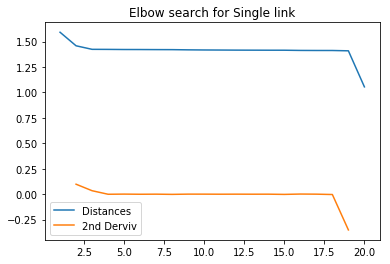

clusters: 16 at max_dist: 1.415258722874392


In [151]:
k_single, maxDist_single = find_elbow(Z_single, 7, title=title)

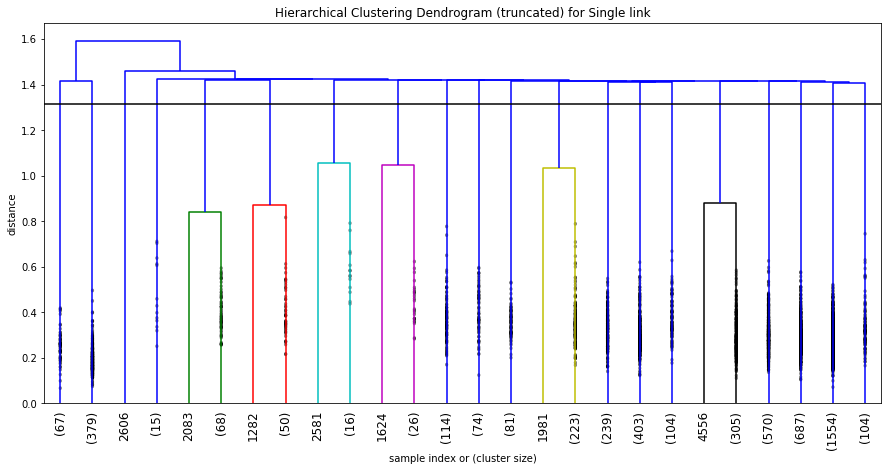

In [152]:
plot_dendogram(Z_single, numClusters=int(k_single)+10, maxDist=maxDist_single-10**(-1), title=title)

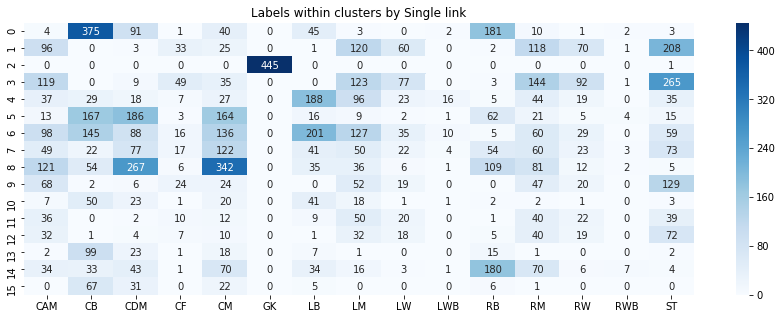

In [153]:
agg_with_kmeans(num_clusters=k_single, title=title)

### Complete Link

In [154]:
title = "Complete link"
Z_complete = linkage(X_train, 'complete')

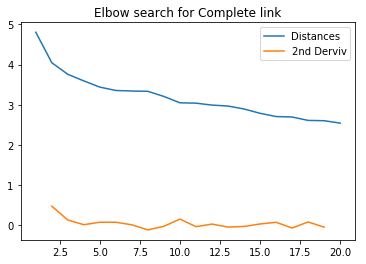

clusters: 10 at max_dist: 3.2044145588624113


In [155]:
k_complete, maxDist_complete= find_elbow(Z_complete, title=title)

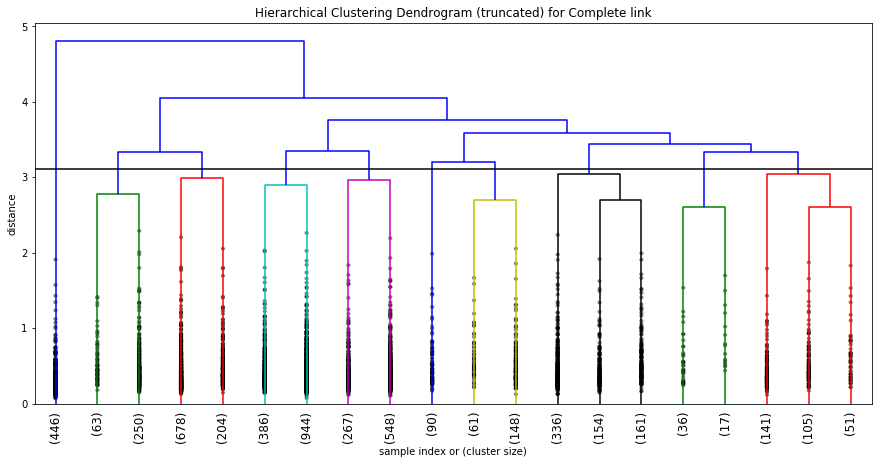

In [156]:
plot_dendogram(Z_complete, numClusters=int(k_complete)+10, maxDist=maxDist_complete-10**(-1), title=title)

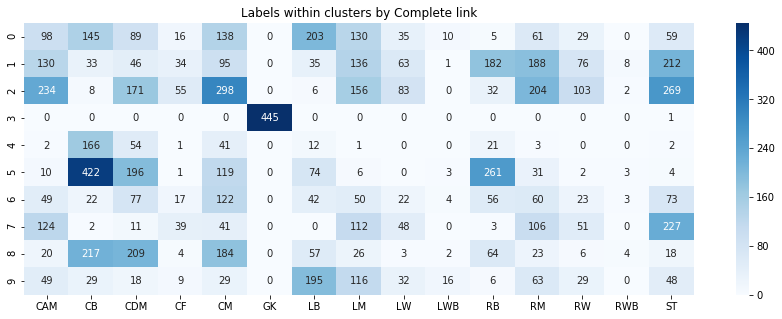

In [157]:
agg_with_kmeans(num_clusters=k_complete, title=title)

### Average Link

In [126]:
title = "Average link"
Z_average = linkage(X_train, 'average')

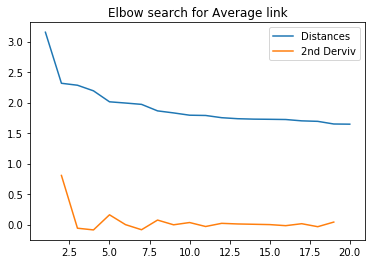

clusters: 8 at max_dist: 1.9708797895041115


In [144]:
k_average, maxDist_average= find_elbow(Z_average, startSearch=5, title=title)

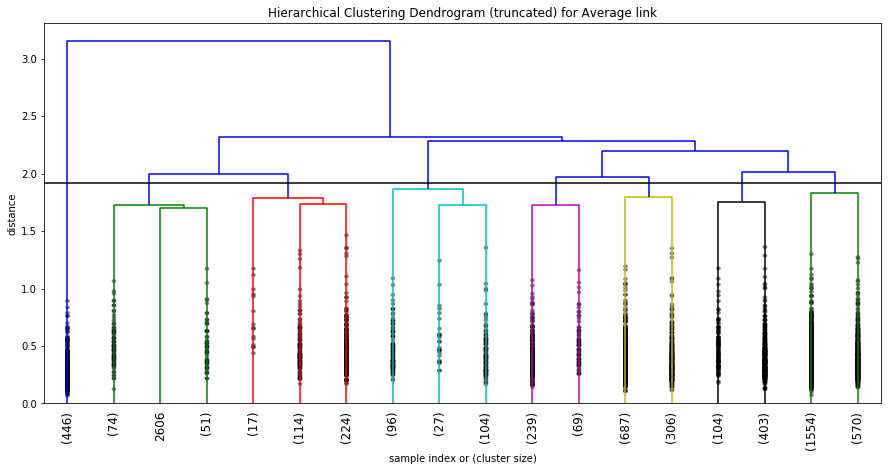

In [148]:
plot_dendogram(Z_average, numClusters=int(k_average)+10, maxDist=maxDist_average-5*10**(-2), title=title)

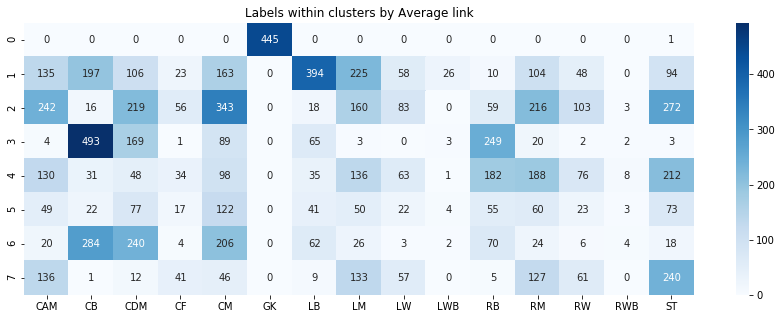

In [149]:
agg_with_kmeans(num_clusters=k_average, title=title)

### Weighted Link

In [159]:
title = "Weighted link"
Z_weighted = linkage(X_train, 'weighted')

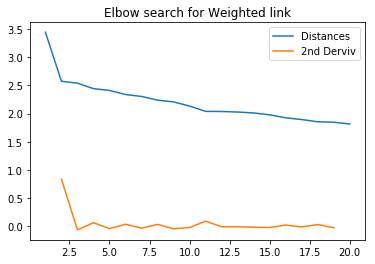

clusters: 11 at max_dist: 2.1337458579628725


In [160]:
k_weighted, maxDist_weighted= find_elbow(Z_weighted, title=title)

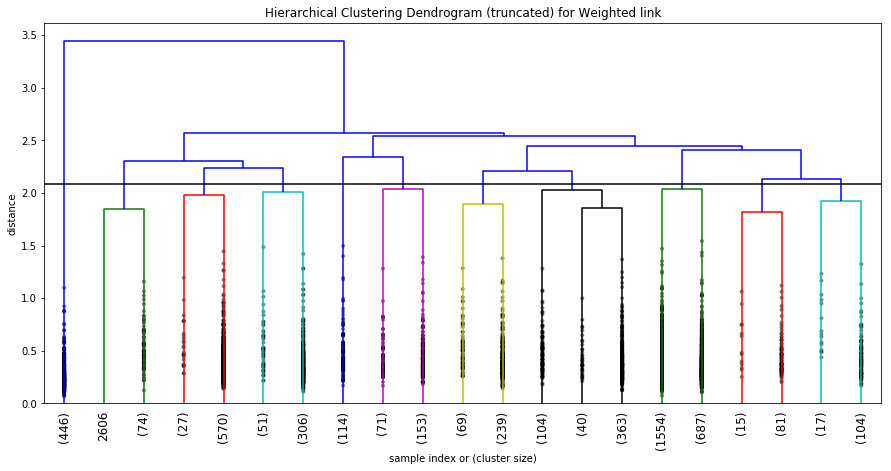

In [162]:
plot_dendogram(Z_weighted, numClusters=int(k_weighted)+10, maxDist=maxDist_weighted-5*10**(-2), title=title)

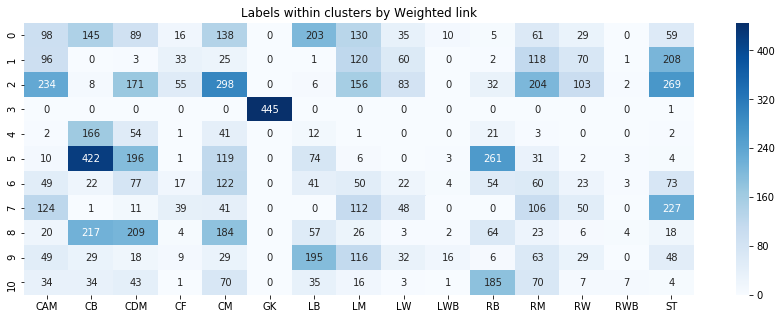

In [163]:
agg_with_kmeans(num_clusters=k_weighted, title=title)

### Ward LInk

In [166]:
title = "Ward link"
Z_ward = linkage(X_train, 'ward')

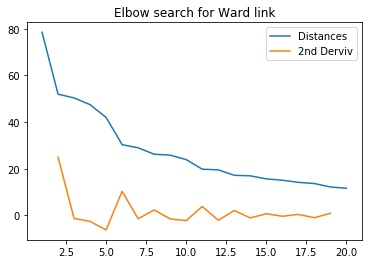

clusters: 6 at max_dist: 42.00325714695142


In [167]:
k_ward, maxDist_ward= find_elbow(Z_ward, title=title)

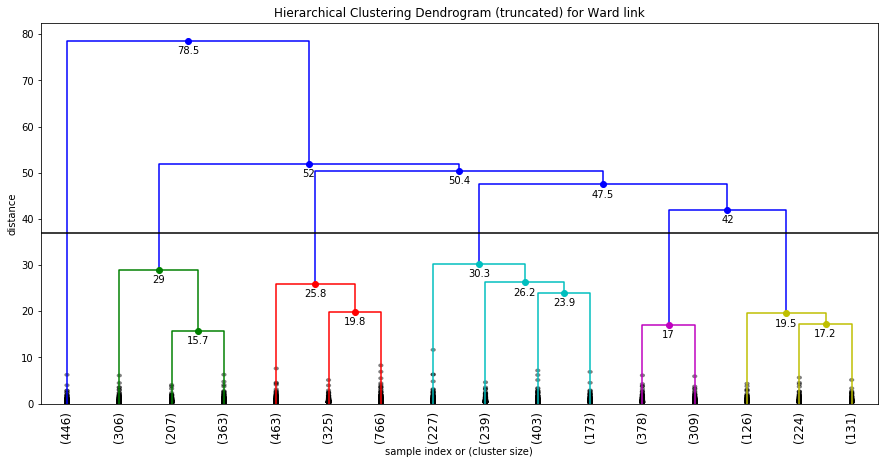

In [169]:
plot_dendogram(Z_ward, numClusters=int(k_ward)+10, maxDist=maxDist_ward-5, title=title)

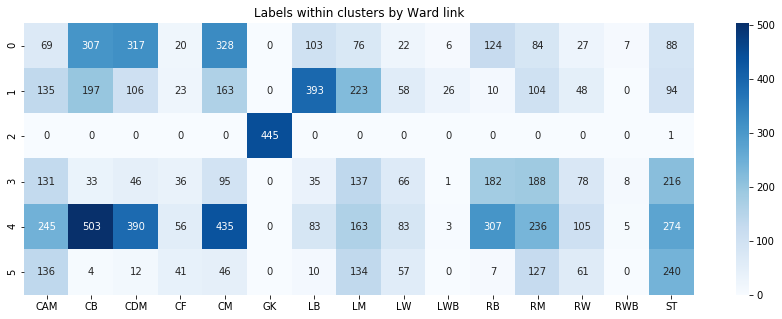

In [170]:
agg_with_kmeans(num_clusters=k_ward, title=title)

# Clustering Evaluation